## Imports

In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys
# from napari_convpaint.conv_paint_utils import *
# from napari_convpaint.conv_paint_model import *
# from napari_convpaint.conv_paint_param import Param
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import napari
from skimage import morphology
import seaborn as sns
import pandas as pd
from aicsimageio import AICSImage

from CellAnalyzer import CellAnalyzer

05-Jun-25 17:47:51 - bfio.backends - WARNING  - Java backend is not available. This could be due to a missing dependency (jpype).


## Load model with the data

Create an object with the path to the data.

In [5]:
in_path = "../imaging_data/21122022_images_jinglecells_SO_AK/MERS"
ca = CellAnalyzer.load(in_path + "/CellAnalyzer/CellAnalyzer.pkl")

>>> GPU activated? NO
>>> GPU activated? NO


### Inspect raw cell means as tables, grouped by different levels

In [7]:
cells_df = ca.cells_df.drop(columns=["time", "date", "sample", "mode1", "mode2", "filename", "filepath", "projection_types"])
cells_df.iloc[1200:1205]

,condition,donor,replicate,cell_id,cilia_mean,inf_mean
1200,37mock,BEC6,1,1201,4685.717466,663.558219
1201,37mock,BEC6,1,1202,5267.037348,680.481707
1202,37mock,BEC6,1,1203,4266.040141,667.770423
1203,37mock,BEC6,1,1204,4862.489869,680.087798
1204,37mock,BEC6,1,1205,4480.508189,664.789017


Per condition:

In [8]:
cells_df.groupby('condition')[['cilia_mean', 'inf_mean']].aggregate(["mean", "std"])

cilia_mean                  inf_mean             
                  mean          std         mean          std
condition                                                    
37mock     4868.170157  2144.241648  1350.299652  1130.117140
MERS       5985.851453  1336.831555  1949.170789  1798.474123

Per condition × donor:

In [9]:
cells_df.groupby(['condition', 'donor'])[['cilia_mean', 'inf_mean']].aggregate(["mean", "std"])

cilia_mean                  inf_mean             
                        mean          std         mean          std
condition donor                                                    
37mock    BEC5   4836.718286  2442.499340  1595.521414  1233.153114
          BEC6   4954.027633   927.064054   680.892058    29.547372
MERS      BEC5   6488.710509  1319.572357  1809.229823  1431.534291
          BEC6   5293.291076  1012.568060  2141.903856  2193.990081

Per replicate (to detect batch effects):

In [10]:
cells_df.groupby(['condition', 'donor', 'replicate'])[['cilia_mean', 'inf_mean']].aggregate(["mean", "std"])

cilia_mean                  inf_mean             
                                  mean          std         mean          std
condition donor replicate                                                    
37mock    BEC5  1          7022.288165  1444.068340   741.339527    42.783408
                2          1705.979285   376.568647   695.869843    35.580668
                3          5466.191595   977.399090  3312.372675   207.013359
          BEC6  1          4954.027633   927.064054   680.892058    29.547372
MERS      BEC5  1          6375.902914  1226.556012  2347.672798  1666.155749
                2          6576.256172  1383.474837  1391.364811  1045.312403
          BEC6  1          5293.291076  1012.568060  2141.903856  2193.990081

### Visualize raw cell means

In [11]:
df_to_show = cells_df.copy()
df_to_show["sample"] = df_to_show["donor"] + "_" + df_to_show["replicate"].astype(str)

Visualize conditions

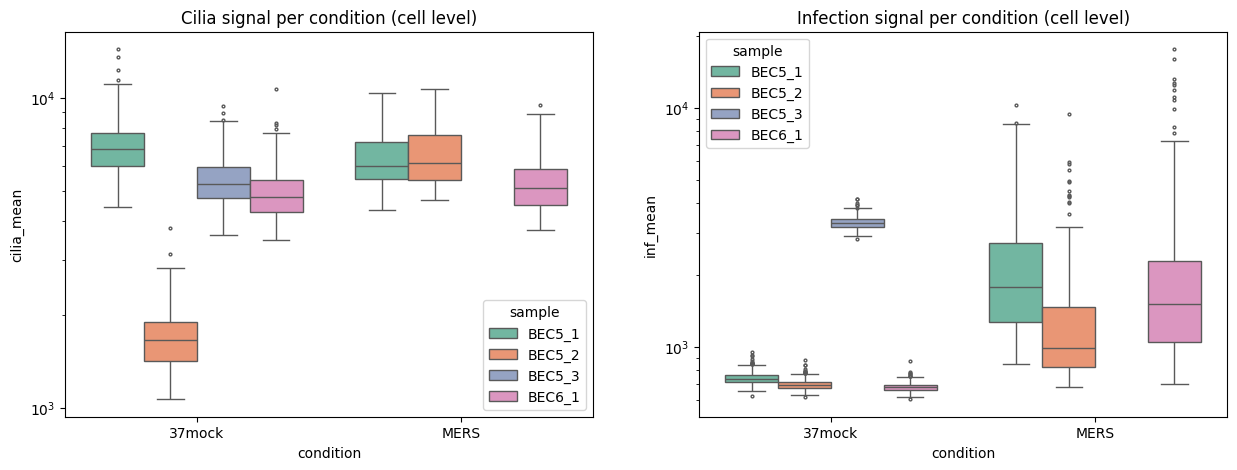

In [12]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))
sns.boxplot(data=df_to_show, x='condition', y='cilia_mean', hue = "sample", palette="Set2", ax=ax[0], log_scale=True, fliersize = 2)
sns.boxplot(data=df_to_show, x='condition', y='inf_mean', hue = "sample", palette="Set2", ax=ax[1], log_scale=True, fliersize = 2)
ax[0].set_title('Cilia signal per condition (cell level)')
ax[1].set_title('Infection signal per condition (cell level)')
plt.show()

Visualize samples

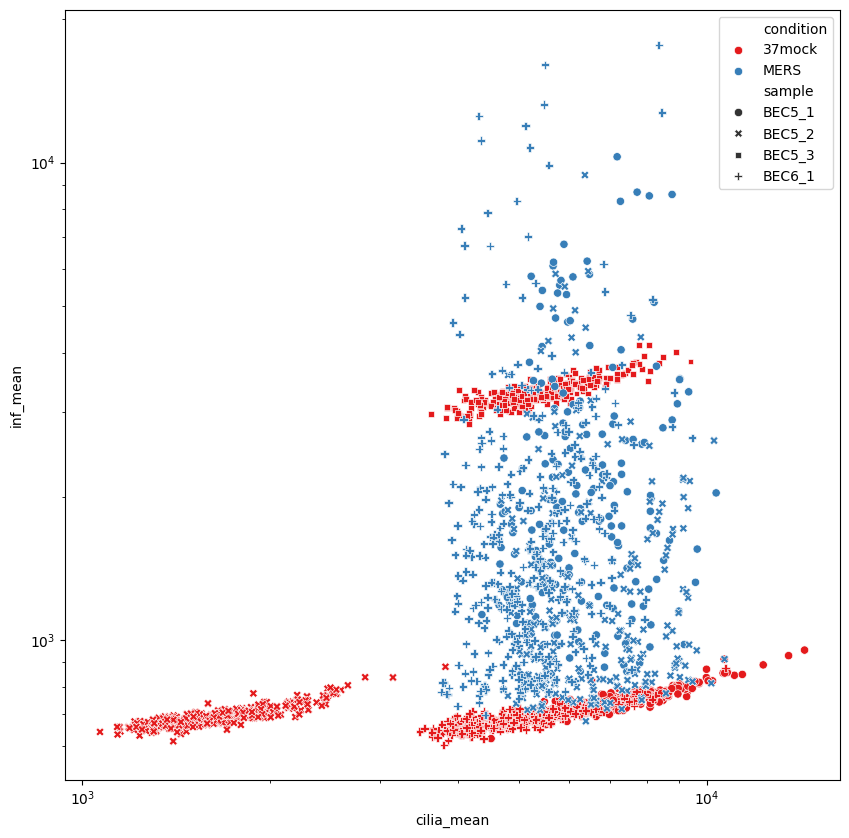

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
# Create a scatter plot for the two conditions
sns.scatterplot(data=df_to_show, x='cilia_mean', y='inf_mean', hue="condition", palette="Set1", style="sample", ax=ax)
plt.xscale('log')
plt.yscale('log')
plt.show()

### Average by replicates

In [14]:
replicate_summary = df_to_show.groupby(['condition', 'donor', 'replicate']).agg({
    'sample': 'first',
    'cilia_mean': 'mean',
    'inf_mean': 'mean' # or 'unique' if you're unsure it's consistent
}).reset_index()
replicate_summary

,condition,donor,replicate,sample,cilia_mean,inf_mean
0,37mock,BEC5,1,BEC5_1,7022.288165,741.339527
1,37mock,BEC5,2,BEC5_2,1705.979285,695.869843
2,37mock,BEC5,3,BEC5_3,5466.191595,3312.372675
3,37mock,BEC6,1,BEC6_1,4954.027633,680.892058
4,MERS,BEC5,1,BEC5_1,6375.902914,2347.672798
5,MERS,BEC5,2,BEC5_2,6576.256172,1391.364811
6,MERS,BEC6,1,BEC6_1,5293.291076,2141.903856


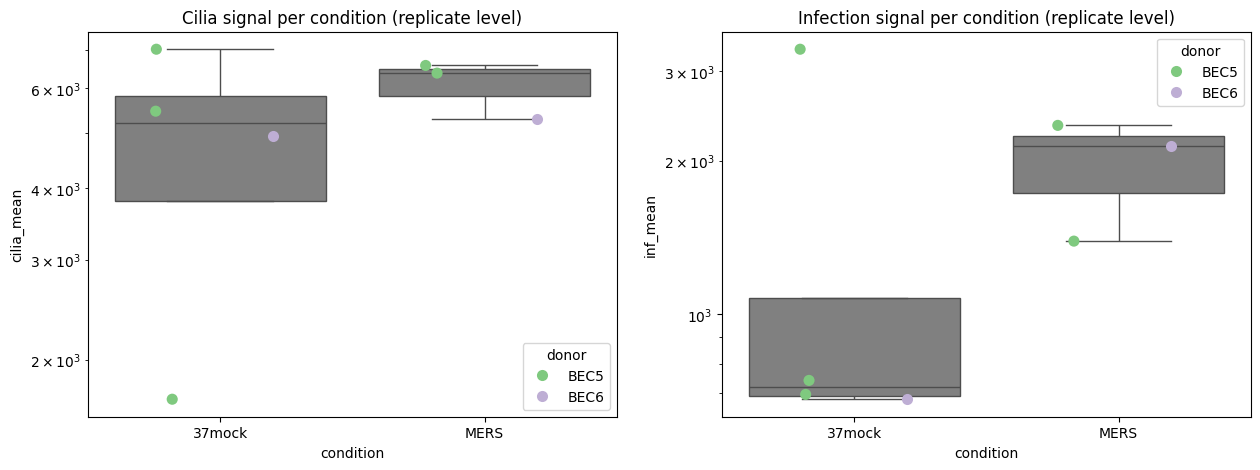

In [15]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))
sns.boxplot(data=replicate_summary, x="condition", y="cilia_mean", ax=ax[0], log_scale=True, fliersize = 0, color='grey')
sns.boxplot(data=replicate_summary, x="condition", y="inf_mean", ax=ax[1], log_scale=True, fliersize = 0, color='grey')
sns.stripplot(data=replicate_summary, x="condition", y="cilia_mean", hue="donor", palette="Accent", dodge=True, ax=ax[0], log_scale=True, size = 8)
sns.stripplot(data=replicate_summary, x="condition", y="inf_mean", hue="donor", palette="Accent", dodge=True, ax=ax[1], log_scale=True, size = 8)
ax[0].set_title('Cilia signal per condition (replicate level)')
ax[1].set_title('Infection signal per condition (replicate level)')
plt.show()

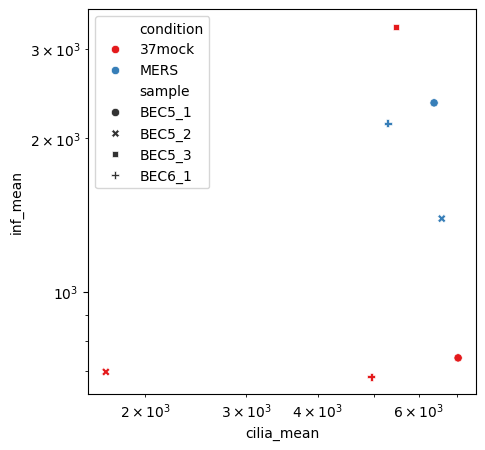

In [16]:
fig, ax = plt.subplots(figsize=(5, 5), dpi= 100)
# Create a scatter plot for the two conditions
sns.scatterplot(data=replicate_summary, x='cilia_mean', y='inf_mean', hue="condition", palette="Set1", style="sample", ax=ax)
plt.xscale('log')
plt.yscale('log')
plt.show()

### Average replicates by donors

In [17]:
donor_summary = df_to_show.groupby(['condition', 'donor']).agg({
    'cilia_mean': 'mean',
    'inf_mean': 'mean',
}).reset_index()
donor_summary

,condition,donor,cilia_mean,inf_mean
0,37mock,BEC5,4836.718286,1595.521414
1,37mock,BEC6,4954.027633,680.892058
2,MERS,BEC5,6488.710509,1809.229823
3,MERS,BEC6,5293.291076,2141.903856


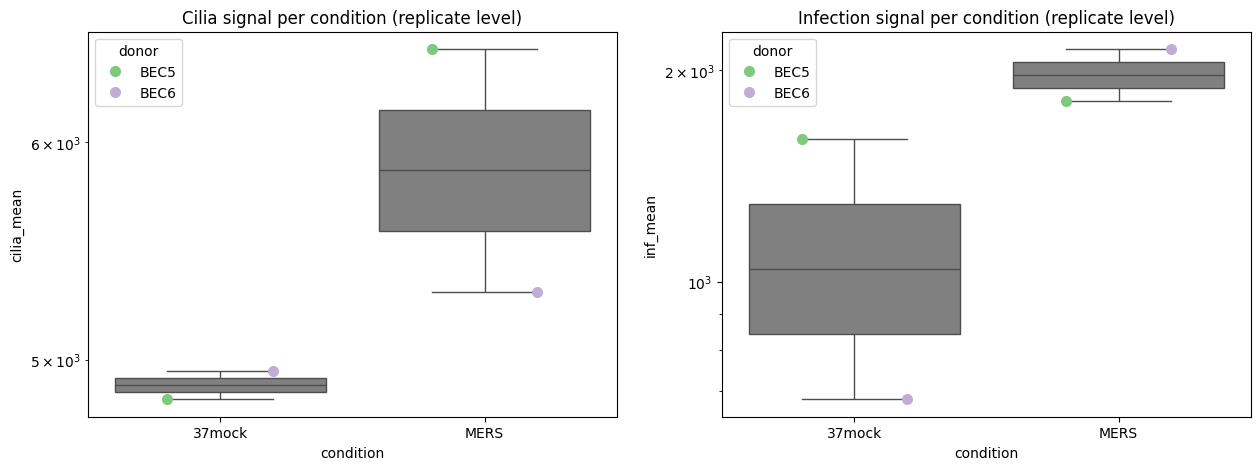

In [18]:
gig, ax = plt.subplots(1,2, figsize=(15, 5))
sns.boxplot(data=donor_summary, x="condition", y="cilia_mean", ax=ax[0], log_scale=True, fliersize = 0, color='grey')
sns.boxplot(data=donor_summary, x="condition", y="inf_mean", ax=ax[1], log_scale=True, fliersize = 0, color='grey')
sns.stripplot(data=donor_summary, x="condition", y="cilia_mean", hue="donor", palette="Accent", dodge=True, ax=ax[0], log_scale=True, size = 8)
sns.stripplot(data=donor_summary, x="condition", y="inf_mean", hue="donor", palette="Accent", dodge=True, ax=ax[1], log_scale=True, size = 8)
ax[0].set_title('Cilia signal per condition (replicate level)')
ax[1].set_title('Infection signal per condition (replicate level)')
plt.show()

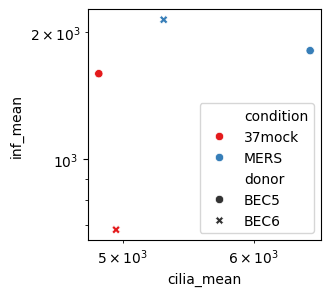

In [19]:
fig, ax = plt.subplots(figsize=(3, 3), dpi= 100)
# Create a scatter plot for the two conditions
sns.scatterplot(data=donor_summary, x='cilia_mean', y='inf_mean', hue="condition", palette="Set1", style="donor", ax=ax)
plt.xscale('log')
plt.yscale('log')
plt.show()